# Reference
https://pyimagesearch.com/2021/11/11/get-started-dcgan-for-fashion-mnist/

In [32]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

In [33]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [34]:
(X_train, y_train), _ = fashion_mnist.load_data()

In [35]:
X_train.shape

(60000, 28, 28)

In [36]:
y_train.shape

(60000,)

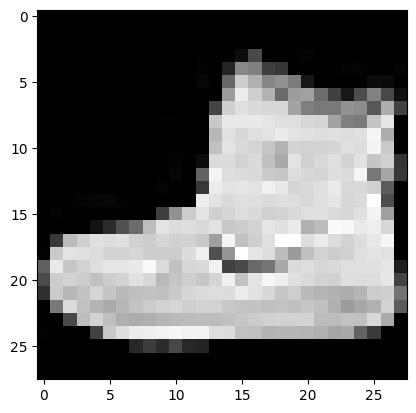

In [37]:
plt.imshow(X_train[0], cmap=plt.cm.gray)

In [38]:
# convert to gray channel
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1).astype(np.float32)

# normalize (256 / 2) gray color range
X_train = (X_train - 128.0) / 128.0

In [39]:
LATENT_DIM = 100
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
CHANNELS = 1

In [40]:
def build_generator():
    model = Sequential(name='generator')

    model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2D(CHANNELS, (5, 5), padding='same', activation='tanh'))

    return model

generator = build_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization_10 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 re_lu_6 (ReLU)              (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 128)      819328    
 ranspose)                                                       
                                                                 
 batch_normalization_11 (Bat  (None, 14, 14, 128)      51

In [41]:
def build_discriminator(width, height, depth, alpha=0.2):
    input_shape = (height, width, depth)
    model = Sequential(name='discriminator')
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

discriminator = build_discriminator(28, 28, CHANNELS)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_13 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_14 (Bat  (None, 7, 7, 128)        512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 128)       

In [42]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim) -> None:
        super().__init__()
        
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
    
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        with tf.GradientTape() as tape:
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)
            
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)
            
            d_loss = (d_loss_real + d_loss_fake) / 2
        
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))
        
        misleading_labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            fake_images = self.generator(noise,  training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))
        
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [43]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100) -> None:
        super().__init__()
        
        self.latent_dim = latent_dim
        self.num_img = num_img
        self.seed = tf.random.normal([16,  latent_dim])
    
    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 128.0) + 128.0
        generated_images.numpy()
        
        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img, cmap=plt.cm.gray)
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()
        
    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [44]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

In [45]:
lr_rate = 0.0002
dcgan.compile(d_optimizer=Adam(learning_rate=lr_rate, beta_1=0.5),
            g_optimizer=Adam(learning_rate=lr_rate, beta_1=0.5),
              loss_fn=keras.losses.BinaryCrossentropy())

Epoch 1/10


2022-12-17 17:01:06.888449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - ETA: 0s - d_loss: 0.0235 - g_loss: 1.3129

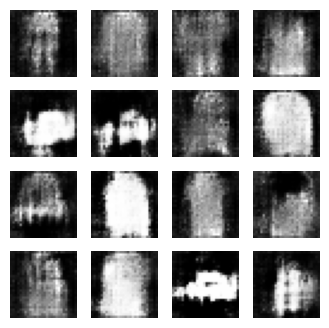

1875/1875 [==============================] - 324s 171ms/step - d_loss: 0.0235 - g_loss: 1.3129
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - d_loss: 0.0012 - g_loss: 0.8556

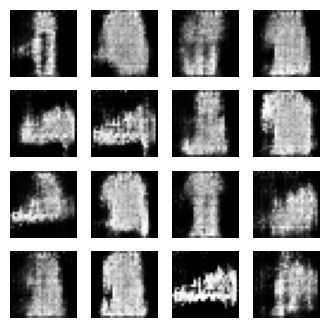

1875/1875 [==============================] - 348s 185ms/step - d_loss: 0.0012 - g_loss: 0.8556
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - d_loss: 2.2440e-04 - g_loss: 0.9131

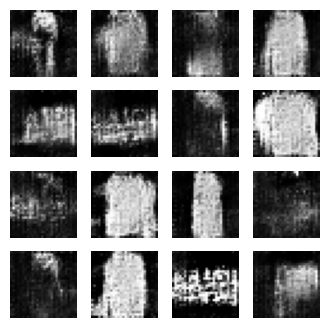

1875/1875 [==============================] - 329s 176ms/step - d_loss: 2.2440e-04 - g_loss: 0.9131
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - d_loss: 8.0579e-05 - g_loss: 1.0584

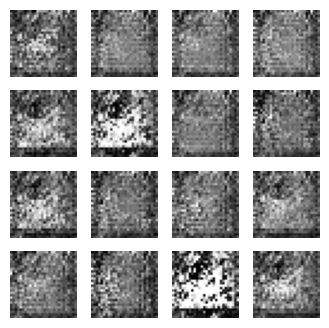

1875/1875 [==============================] - 234s 125ms/step - d_loss: 8.0579e-05 - g_loss: 1.0584
Epoch 5/10
1875/1875 [==============================] - ETA: 0s - d_loss: 2.5684e-05 - g_loss: 0.9258

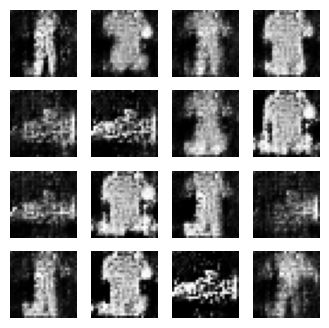

1875/1875 [==============================] - 234s 125ms/step - d_loss: 2.5684e-05 - g_loss: 0.9258
Epoch 6/10
1875/1875 [==============================] - ETA: 0s - d_loss: 9.0350e-06 - g_loss: 1.1019

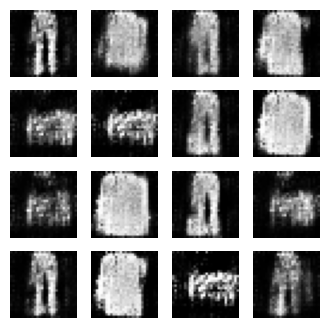

1875/1875 [==============================] - 225s 120ms/step - d_loss: 9.0350e-06 - g_loss: 1.1019
Epoch 7/10
1875/1875 [==============================] - ETA: 0s - d_loss: 2.7648e-06 - g_loss: 1.1720

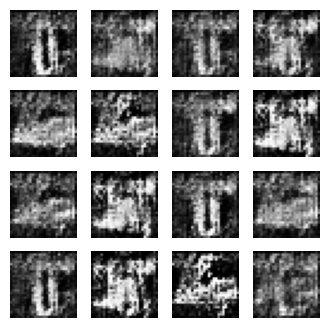

1875/1875 [==============================] - 229s 122ms/step - d_loss: 2.7648e-06 - g_loss: 1.1720
Epoch 8/10
1875/1875 [==============================] - ETA: 0s - d_loss: 1.1514e-06 - g_loss: 1.2761

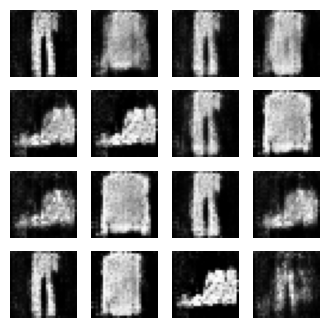

1875/1875 [==============================] - 229s 122ms/step - d_loss: 1.1514e-06 - g_loss: 1.2761
Epoch 9/10
1875/1875 [==============================] - ETA: 0s - d_loss: 4.1373e-07 - g_loss: 1.3484

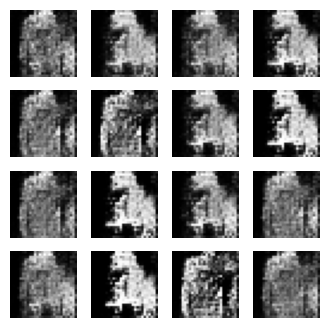

1875/1875 [==============================] - 229s 122ms/step - d_loss: 4.1373e-07 - g_loss: 1.3484
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - d_loss: 1.6366e-07 - g_loss: 1.3963

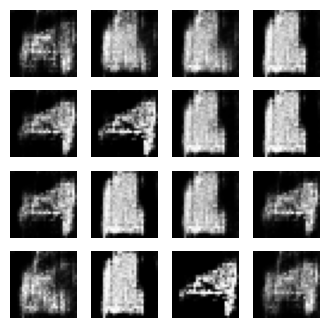

1875/1875 [==============================] - 2009s 1s/step - d_loss: 1.6366e-07 - g_loss: 1.3963


In [46]:
dcgan.fit(X_train, epochs=10, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])